<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%84%9C%EC%9A%B8_%EB%9E%9C%EB%93%9C%EB%A7%88%ED%81%AC_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

서울 랜드마크 이미지 분류 경진대회 https://dacon.io/competitions/official/235957/overview/description

# modeule

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import glob
import tqdm 
import tensorflow as tf
from tensorflow.keras import layers
import shutil
import os
import albumentations as A

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# data load

In [ ]:
train_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/서울 렌드마크/train.csv')

In [ ]:
test_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/서울 렌드마크/test.csv')

# EDA

In [ ]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  723 non-null    object
 1   label      723 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB


In [ ]:
train_csv.head()

,file_name,label
0,001.PNG,9
1,002.PNG,4
2,003.PNG,1
3,004.PNG,1
4,005.PNG,6


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


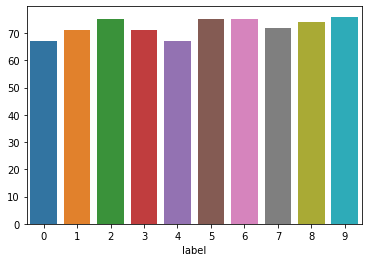

In [ ]:
label_ct = train_csv.value_counts('label')
sns.barplot(label_ct.index, label_ct)
plt.show()

In [ ]:
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  199 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB


In [ ]:
train_list = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/데이콘/서울 렌드마크/train/*'))
test_list = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/데이콘/서울 렌드마크/test/*'))

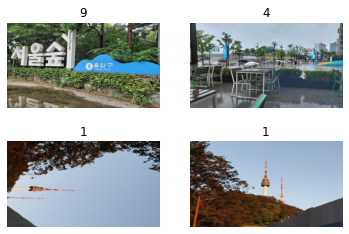

In [ ]:
for i in range(4):
    plt.subplot(2,2,i+1)
    img = PIL.Image.open(train_list[i])
    plt.title(train_csv.label[i])
    plt.imshow(img)
    plt.axis(False)
plt.show()

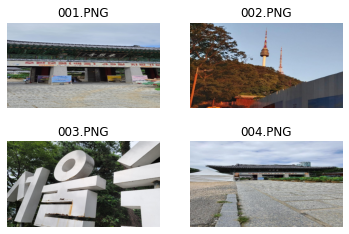

In [ ]:
for i in range(4):
    plt.subplot(2,2,i+1)
    img = PIL.Image.open(test_list[i])
    plt.title(test_list[i].split('/')[-1])
    plt.imshow(img)
    plt.axis(False)
plt.show()

In [ ]:
train_size_h = []
train_size_w = []
for i in tqdm.tqdm(train_list):
    size = PIL.Image.open(i).size
    train_size_h.append(size[0])
    train_size_w.append(size[1])
train_csv['size_h'] = train_size_h
train_csv['size_w'] = train_size_w

test_size_h = []
test_size_w = []
for i in tqdm.tqdm(test_list):
    size = PIL.Image.open(i).size
    test_size_h.append(size[0])
    test_size_w.append(size[1])
test_csv['size_h'] = test_size_h
test_csv['size_w'] = test_size_w

100%|██████████| 199/199 [00:59<00:00,  3.32it/s]


In [ ]:
print(train_csv.size_h.max(), train_csv.size_h.min())
print(train_csv.size_w.max(), train_csv.size_w.min())
print(test_csv.size_h.max(), test_csv.size_h.min())
print(test_csv.size_w.max(), test_csv.size_w.min())

960 960
540 540
960 960
540 540


# make dataset

In [ ]:
train_list = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/데이콘/서울 렌드마크/train/*'))
test_list = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/데이콘/서울 렌드마크/test/*'))

In [ ]:
for i in range(10):
    os.mkdir(f'/content/drive/MyDrive/Colab Notebooks/데이콘/서울 렌드마크/train/{i}')

FileExistsError: ignored

In [ ]:
for i in range(len(train_list)):
    label = train_csv.label[i]
    shutil.move(train_list[i], f'/content/drive/MyDrive/Colab Notebooks/데이콘/서울 렌드마크/train/{label}')

In [ ]:
image_size = (128,128)#(500,500)
train_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/데이콘/서울 렌드마크/train',
                                                               image_size = image_size,
                                                               subset='training',
                                                               validation_split=0.2,
                                                               seed=42)

Found 723 files belonging to 10 classes.
Using 579 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/데이콘/서울 렌드마크/train',
                                                               image_size = image_size,
                                                               subset='validation',
                                                               validation_split=0.2,
                                                               seed=42)

Found 723 files belonging to 10 classes.
Using 144 files for validation.


In [102]:
transformer = A.Compose([A.HorizontalFlip(),
                         #A.ShiftScaleRotate(),
                         A.RandomBrightnessContrast(),
                         ])

In [ ]:
aaa = tf.constant([4])
aaa.numpy()

array([4], dtype=int32)

In [103]:
def algument(img):
    image_dic = {'image':img}
    aug_img = transformer(**image_dic)
    aug_img = tf.cast(aug_img['image'], tf.float32)

    return aug_img

def trans(img, label):
    img = tf.numpy_function(func = algument, inp=[img], Tout=tf.float32)
    return img, label

In [106]:
data_x = train_ds.map(trans)

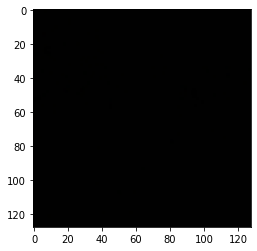

In [114]:
plt.imshow(next(iter(data_x))[0][0].numpy().astype('uint'))
plt.show()

In [ ]:
train_ds_x = train_ds.map(algument)
plt.imshow(next(iter(train_ds_x))[0][0])

AttributeError: ignored

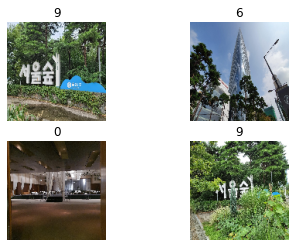

In [ ]:
class_names = train_ds.class_names
for i,j in train_ds.take(1):
    for k in range(4):
        plt.subplot(2,2,k+1)
        img = i[k].numpy().astype('uint')
        plt.title(class_names[j[k]])
        plt.imshow(img)
        plt.axis(False)
plt.show()

# modeling

In [ ]:
def model_make1():
    inputs = tf.keras.Input(shape=(image_size[0],image_size[1],3))
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = layers.experimental.preprocessing.RandomFlip('horizontal')(x)
    x = layers.experimental.preprocessing.RandomRotation(0.1)(x)
    x = layers.experimental.preprocessing.RandomZoom(0.1)(x)

    x = layers.Conv2D(32, 3, padding='same', activation = 'relu')(x)
    x = layers.Conv2D(32, 3, activation = 'relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation = 'relu')(x)
    x = layers.Conv2D(64, 3, activation = 'relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(128, 3, padding='same', activation = 'relu')(x)
    x = layers.Conv2D(128, 3, activation = 'relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.1)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = model_make1()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 500, 500, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 500, 500, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 500, 500, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 500, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 32)      896       
                                                             

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
19/19 [==============================] - 1106s 55s/step - loss: 2.9514 - accuracy: 0.1157 - val_loss: 2.3109 - val_accuracy: 0.0972
Epoch 2/30
19/19 [==============================] - 1058s 55s/step - loss: 2.9089 - accuracy: 0.1088 - val_loss: 2.3211 - val_accuracy: 0.0972
Epoch 3/30
19/19 [==============================] - 1023s 54s/step - loss: 2.8433 - accuracy: 0.1123 - val_loss: 2.3337 - val_accuracy: 0.0972
Epoch 4/30
19/19 [==============================] - 1030s 54s/step - loss: 2.7001 - accuracy: 0.1313 - val_loss: 2.3455 - val_accuracy: 0.0972
Epoch 5/30
19/19 [==============================] - 1047s 55s/step - loss: 2.6753 - accuracy: 0.1744 - val_loss: 2.3543 - val_accuracy: 0.0972
Epoch 6/30
19/19 [==============================] - 1029s 54s/step - loss: 2.4345 - accuracy: 0.2142 - val_loss: 2.3608 - val_accuracy: 0.0972
Epoch 7/30
19/19 [==============================] - 1067s 56s/step - loss: 2.4896 - accuracy: 0.2073 - val_loss: 2.3657 - val_accuracy: 0.0972

KeyboardInterrupt: ignored

# modeling2

In [ ]:
prepro = tf.keras.applications.efficientnet_v2.preprocess_input #mobilenet_v3.preprocess_input
base_model = tf.keras.applications.EfficientNetV2B0(input_shape=(image_size[0],image_size[1],3),include_top=False,weights='imagenet')
base_model.trainable = False

24289280/24274472 [==============================] - 1s 0us/step


In [ ]:
prepro = tf.keras.applications.resnet50.preprocess_input #mobilenet_v3.preprocess_input
base_model = tf.keras.applications.ResNet50V2(input_shape=(image_size[0],image_size[1],3),include_top=False,weights='imagenet')
base_model.trainable = False

94683136/94668760 [==============================] - 0s 0us/step


In [ ]:
for i in base_model.layers[230:]:
    i.trainable=True

In [ ]:
def model_make2():
    inputs = layers.Input(shape=(image_size[0],image_size[1],3))
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = layers.experimental.preprocessing.RandomFlip('horizontal')(x)
    x = layers.experimental.preprocessing.RandomRotation(0.1)(x)
    x = layers.experimental.preprocessing.RandomZoom(0.1)(x)
    x = prepro(x) 
    x = base_model(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.2)(x)
    # x = layers.Dense(512, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = model_make2()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                         

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model = tf.keras.models.load_model('/content/seoul2.h5')

OSError: ignored

In [ ]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
19/19 [==============================] - 14s 392ms/step - loss: 11389.8965 - accuracy: 0.0829 - val_loss: 1630.2334 - val_accuracy: 0.1042
Epoch 2/50
19/19 [==============================] - 13s 509ms/step - loss: 747.7390 - accuracy: 0.1088 - val_loss: 2.3024 - val_accuracy: 0.1111
Epoch 3/50
19/19 [==============================] - 9s 328ms/step - loss: 2.3027 - accuracy: 0.0881 - val_loss: 2.3025 - val_accuracy: 0.1111
Epoch 4/50
19/19 [==============================] - 9s 324ms/step - loss: 2.3026 - accuracy: 0.0933 - val_loss: 2.3025 - val_accuracy: 0.0694
Epoch 5/50
19/19 [==============================] - 9s 324ms/step - loss: 2.3026 - accuracy: 0.1140 - val_loss: 2.3028 - val_accuracy: 0.0694
Epoch 6/50
19/19 [==============================] - 9s 327ms/step - loss: 2.3025 - accuracy: 0.1140 - val_loss: 2.3029 - val_accuracy: 0.0694
Epoch 7/50
19/19 [==============================] - 9s 325ms/step - loss: 2.3024 - accuracy: 0.1140 - val_loss: 2.3031 - val_accuracy: 0.

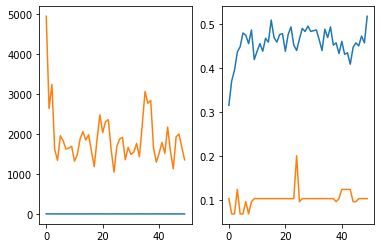

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

In [ ]:
model.save('seoul4.h5')